### Домашнее задание

Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

По шагам:
0. выбрать себе датасет (который интересен или нравится больше всего), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
1. установить удобную для себя среду разработки (pycharm прекрасен - https://www.jetbrains.com/pycharm/)
2. для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта конечно же при этом)
3. завести себе аккаунт на github (если его еще нет). У самого github есть такой "hello world" по работе с ним - https://guides.github.com/activities/hello-world/
4. итоговый проект должен содержать: 1) каталог app/models/ (здесь модель-пайплайн предобученная либо код обучения модели-пайплайна) 2) файл app/run_server.py (здесь основной код flask-приложения) 3) requirements.txt (список пакетов, которые у вас используются в проекте - в корне проекта) 4) README.md (здесь какое-то описание, что вы делаете, что за данные, как запускать и т.д) 5) Dockerfile 6) docker-entrypoint.sh
5. (<b>Опционально</b>): front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

Полезные ссылки:
1. датасеты (для полета мысли): https://www.kaggle.com/datasets
2. конкурс Сбербанка по недвижимости (можно этот набор данных также взять и обучить модель предсказывать стоимость жилья - неплохой такой сервис может получиться) - https://www.kaggle.com/c/sberbank-russian-housing-market/data Там же и ноутбуки с разными подходами есть.
3. минималистичный пример связки keras/flask https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html для определения класса картинки
4. неплохой такой пример (помимо того, что разобрали на занятии) связки docker/flask - https://cloud.croc.ru/blog/byt-v-teme/flask-prilozheniya-v-docker/
5. https://www.digitalocean.com/community/tutorials/how-to-build-and-deploy-a-flask-application-using-docker-on-ubuntu-18-04

p.s. если проблемы с выбором датасета, то пишите пожалуйста - будем вместе думать)

https://archive.ics.uci.edu/ml/datasets/Adult

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
import shap
import dill
import pickle

%matplotlib inline

In [3]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
    ]

In [4]:
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
    names=columns
    )
df.shape

(32561, 15)

In [5]:
df.head().T

,0,1,2,3,4
age,39,50,38,53,28
workclass,State-gov,Self-emp-not-inc,Private,Private,Private
fnlwgt,77516,83311,215646,234721,338409
education,Bachelors,Bachelors,HS-grad,11th,Bachelors
education-num,13,13,9,7,13
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife
race,White,White,White,Black,Black
sex,Male,Male,Male,Male,Female


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
for col in df.select_dtypes(include=['object']).columns:
    if ' ?' in df[col].unique():
        df.loc[df[col] == ' ?', col] = 'other'

In [9]:
df = df.drop_duplicates()
df.shape

(32537, 15)

In [10]:
# Присвоим людям с доходом менее 50 тысяч нулевой класс (0), с доходом более 50 тысяч - первый класс (1).
for pattern, value in zip((r'<=50K', r'>50K'), (0, 1)):
    df.replace({'income': pattern}, {'income': value}, regex=True, inplace=True)
df['income'] = df['income'].astype('uint8')
df.income.value_counts(normalize=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    0.759074
1    0.240926
Name: income, dtype: float64

В наборе данных наблюдается дисбаланс классов.

In [11]:
numerical_features = list(df.select_dtypes(include=['int64']).columns)
categorical_features = list(df.select_dtypes(include=['object']).columns)
numerical_features.remove('fnlwgt')
numerical_features

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

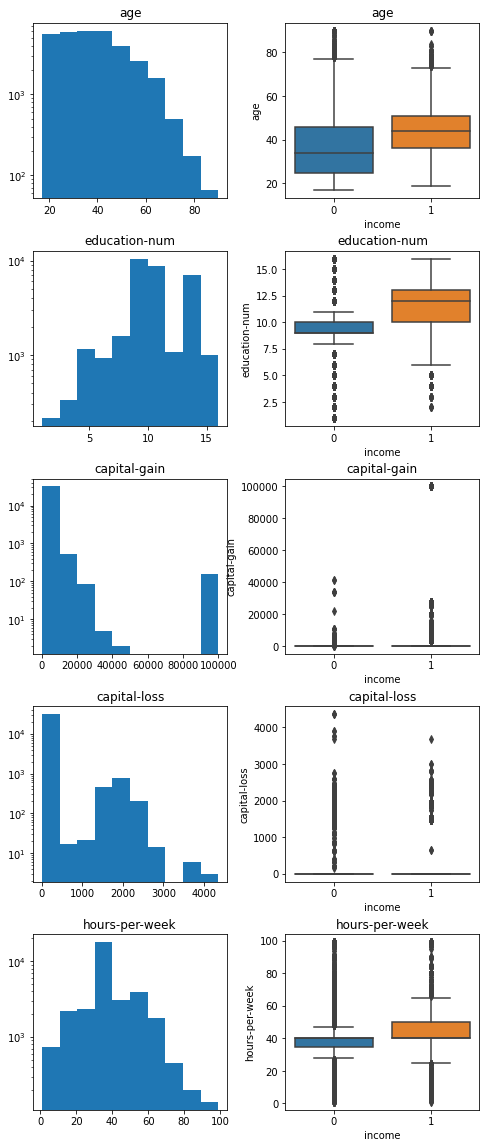

In [12]:
num_cols = 2
num_rows = len(numerical_features)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
counter = 0
for ax in axes.ravel():
    if counter % 2 == 0:
        ax.hist(df[numerical_features[counter // 2]])
        ax.set_title(f'{numerical_features[counter // 2]}')
        ax.set_yscale('log')
    else:
        sns.boxplot(ax=ax, data=df, y=numerical_features[counter // 2], x='income')
        ax.set_title(f'{numerical_features[counter // 2]}')
    counter += 1
    if counter == len(numerical_features) * 2:
        break
plt.show()

In [13]:
df.corr()[:-1]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,-0.076447,0.036224,0.077676,0.057745,0.068515,0.234037
fnlwgt,-0.076447,1.000000,-0.043388,0.000429,-0.010260,-0.018898,-0.009502
education-num,0.036224,-0.043388,1.000000,0.122664,0.079892,0.148422,0.335272
capital-gain,0.077676,0.000429,0.122664,1.000000,-0.031639,0.078408,0.223336
capital-loss,0.057745,-0.010260,0.079892,-0.031639,1.000000,0.054229,0.150501
hours-per-week,0.068515,-0.018898,0.148422,0.078408,0.054229,1.000000,0.229658


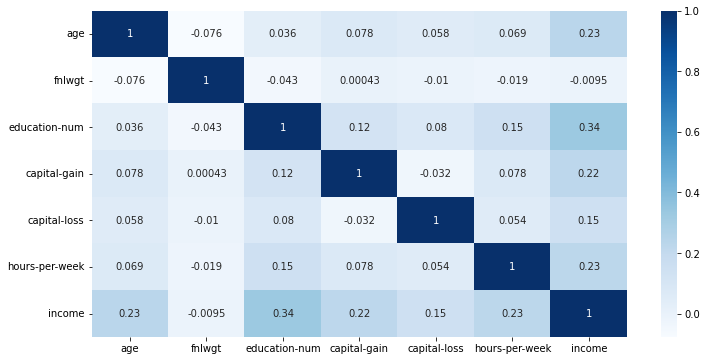

In [14]:
cor = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor, cmap='Blues', annot=True)
plt.show()

In [15]:
class CategorySelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key].apply(lambda x : x.lower().strip())
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        drop_first = True if len(X.unique()) == 2 else False
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key, drop_first=drop_first).columns]
        return self

    def transform(self, X):
        if len(self.columns) == 2:
            X = pd.get_dummies(X, prefix=self.key, drop_first=True)
        else:
            X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [16]:
def build_pipelines(numerical_features=None, categorical_features=None):
    pipeline_list = []
    if categorical_features:
        for feature in categorical_features:
            current_pipeline =  Pipeline([
                                      ('selector', CategorySelector(key=feature)),
                                      ('mle', ModifiedLabelEncoder()),
                                      ('scaler', MinMaxScaler())
                                      ])
            pipeline_list.append((feature, current_pipeline))

    if numerical_features:
        for feature in numerical_features:
            current_pipeline =  Pipeline([
                                      ('selector', NumberSelector(key=feature)),
                                      ('scaler', MinMaxScaler())
                                      ])
            pipeline_list.append((feature, current_pipeline))

    feats = FeatureUnion(pipeline_list)
    return feats

In [17]:
feats = build_pipelines(
    numerical_features=numerical_features, categorical_features=categorical_features
    )

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['fnlwgt', 'income'], axis=1),
    df['income'], test_size=0.3, random_state=100
    )
X_train.shape

(22775, 13)

In [19]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=100)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('workclass',
                                                 Pipeline(steps=[('selector',
                                                                  CategorySelector(key='workclass')),
                                                                 ('mle',
                                                                  ModifiedLabelEncoder()),
                                                                 ('scaler',
                                                                  MinMaxScaler())])),
                                                ('education',
                                                 Pipeline(steps=[('selector',
                                                                  CategorySelector(key='education')),
                                                                 ('mle',
                                                                  ModifiedLabelEncoder()

In [20]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0123514 , 0.00671754, 0.0311602 , 0.82477299, 0.10507509,
       0.34553903, 0.00654479, 0.06124786, 0.01930707, 0.18183261])

In [38]:
preds[0]

0.012351395337155164

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.387832, F-Score=0.724, Precision=0.726, Recall=0.723


In [22]:
y_predict = preds > thresholds[ix]
y_predict[:5]

array([False, False, False,  True, False])

In [23]:
with open('best_threshold.pickle', 'wb') as f:
    pickle.dump(thresholds[ix], f)

In [24]:
with open('best_threshold.pickle', 'rb') as f:
    best_threshold = pickle.load(f)

In [25]:
best_threshold

0.3878320184127259

In [26]:
# y_predict = pipeline.predict(X_test)

In [27]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))
    accuracy = accuracy_score(y_test, y_predict)
    print("accuracy: %.2f%%" % (accuracy * 100.0)) 

In [28]:
evaluate_results(y_test, y_predict)

Classification results:
f1: 72.41%
roc: 81.76%
recall: 72.24%
precision: 72.58%
accuracy: 86.67%


In [29]:
model = pipeline.named_steps['classifier']
model

GradientBoostingClassifier(random_state=100)

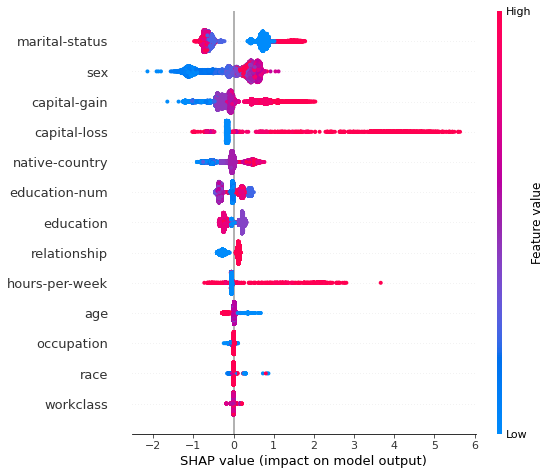

In [30]:
explainer = shap.TreeExplainer(model)
X_train_mod = pd.DataFrame(feats.transform(X_train), columns=X_train.columns)
shap_values = explainer.shap_values(X_train_mod)
shap.summary_plot(shap_values, X_train_mod)
shap.initjs()

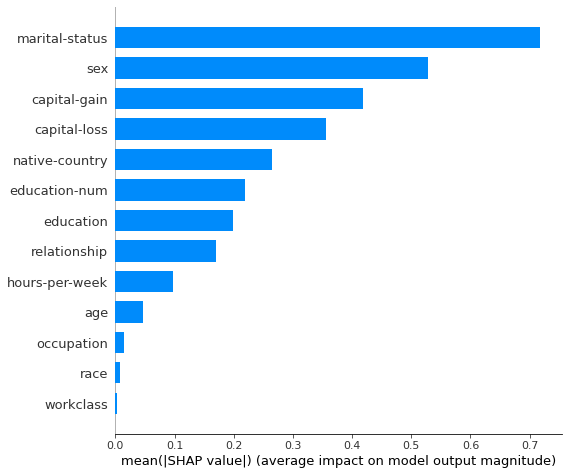

In [31]:
shap.summary_plot(shap_values, X_train_mod, plot_type="bar")

In [32]:
sv = np.abs(shap_values[:, :]).mean(0)
cols = X_train_mod.columns
importance_df = pd.DataFrame({
    "column_name": cols,
    "shap_values": sv
})
#expected result
importance_df = importance_df.sort_values("shap_values", ascending=False)

In [33]:
importance_df[importance_df['shap_values'] > .05]

,column_name,shap_values
4,marital-status,0.718070
8,sex,0.527425
9,capital-gain,0.418473
10,capital-loss,0.355373
12,native-country,0.265153
3,education-num,0.218546
2,education,0.198944
6,relationship,0.169275
11,hours-per-week,0.097975


In [34]:
with open("model.dill", "wb") as f:
    dill.dump(pipeline, f)